# Source Code Description

### This is the implementation of my proposed model: Its a 2 stage constrastive learning model. In the 1st stage the base model learn to discriminate among the calsses. In the 2nd stage the downstream task (classification) is learnt by freezing the 1st satged layers but learning with added classifier dense layer

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm import tqdm, tqdm_notebook
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from pytorch_metric_learning import losses # type: ignore

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 4070 Laptop GPU'

# Pretrained VGG16 base model

In [3]:
# model_name = 'xception'
# model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
# model = torchvision.models.resnet50(False, True)
model = torchvision.models.vgg16_bn(False, True)

c:\Users\robiul\anaconda3\envs\deep_learning\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' and 'progress' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\robiul\anaconda3\envs\deep_learning\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [5]:
#128-D embedding space
# model.last_linear = nn.Sequential(
#     nn.Linear(2048, 128),
#     nn.ReLU()
# )

# model.fc = nn.Sequential(
#     nn.Linear(2048, 512, True),
#     nn.ReLU()
# )
model.classifier[3] = nn.Linear(4096, 128)
model.classifier[4] = nn.Identity()
model.classifier[5] = nn.Identity()
model.classifier[6] = nn.Identity()

In [6]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# random Augmentation

In [7]:
aug = A.Compose([
    #A.RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p=1.0),
    A.OneOf([
        A.Rotate(limit=90, p=1, border_mode=cv2.BORDER_CONSTANT),
        A.Rotate(limit=270, p=1, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=1),
        A.VerticalFlip(p=1)
    ], p=1)
])

# Dataframe creation

In [62]:
# Path to the parent directory containing class folders
parent_dir = "Cropped_CK/"
# Initialize lists to store image names and labels
image_names = []
labels = []

# Get sorted class names to ensure numeric labels are consistent
class_names = sorted(os.listdir(parent_dir))
class_names

['anger',
 'contempt',
 'disgust',
 'fear',
 'happiness',
 'neutral',
 'sadness',
 'surprise']

In [13]:
# Iterate over each class folder with a numeric label
for numeric_label, class_name in enumerate(class_names):
    class_path = os.path.join(parent_dir, class_name)
    if os.path.isdir(class_path):  # Ensure it's a directory
        for image_name in os.listdir(class_path):
            # Add image name and numeric label
            image_names.append(image_name)
            labels.append(numeric_label)
# Create a dataframe
df = pd.DataFrame({
    'id_code': image_names,
    'diagnosis': labels
})

In [14]:
df

,id_code,diagnosis
0,aug_S010_004_00000019.png,0
1,aug_S011_004_00000021.png,0
2,aug_S014_003_00000030.png,0
3,aug_S022_005_00000032.png,0
4,aug_S026_003_00000015.png,0
...,...,...
1230,S133_009_00000006.png,7
1231,S135_001_00000039.png,7
1232,S136_001_00000019.png,7
1233,S137_001_00000014.png,7


In [15]:
# Save to CSV (optional)
df.to_csv("cropped_images.csv", index=False)

# Use the saved dataframe (all images in one folder)

In [8]:
df = pd.read_csv('cropped_images.csv')
image_dir = 'all_ck_images/'
train_df, val_df = train_test_split(df, test_size = 0.20, shuffle=True, random_state= 44, stratify = df['diagnosis'])
transform = transforms.Compose([
            transforms.Resize(size=(224, 224), interpolation=Image.NEAREST),
            transforms.ToTensor()
])

In [9]:
class CustomDataset(Dataset):
    def __init__(self, df, image_dir, transform= None, aug = None):
        super(CustomDataset, self).__init__()
        self.image_ids = list(df['id_code'])
        self.labels = list(df['diagnosis'])
        self.image_dir = image_dir
        self.transform = transform
        self.aug = aug

    def __getitem__(self, idx):
        file_name = self.image_ids[idx]
        label = self.labels[idx]
        image = Image.open(self.image_dir+file_name).convert('RGB')
        aug_image = np.array(image)
        if self.aug:
            aug_image = self.aug(image=aug_image)
            image2 = transforms.ToPILImage()(aug_image['image'])
        if self.transform:
            image2 = self.transform(image2)
            image = self.transform(image)
        label = torch.tensor(label)
        return image, image2, label

    def __len__(self):
        return len(self.image_ids)

In [10]:
train_dataset = CustomDataset(train_df, image_dir, transform=transform, aug= aug)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [11]:
test_dataset = CustomDataset(val_df, image_dir, transform=transform, aug = aug)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# 1st stage constrastive learning

In [12]:
class Siamese_Encoder(nn.Module):
    def __init__(self, encoder):
        super(Siamese_Encoder, self).__init__()
        self.encoder = encoder
    
    def forward(self, x):
        return self.encoder(x)
    """
    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        return out1, out2
    """

In [13]:
model = Siamese_Encoder(model)

In [14]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#criterion = SupervisedContrastiveLoss(temperature=0.07)
criterion = losses.SupConLoss(temperature=0.1)

In [15]:
training_loss = []
valid_loss_min = np.inf

In [23]:
os.mkdir("./saved_model/")

In [ ]:
for n in range(100):
    train_loss = 0.0
    model.train()
    for batch in tqdm(train_dataloader, leave=False):
        x1, x2, y = batch
        x1 = x1.to(device)
        x2 = x2.to(device)
        y = torch.from_numpy(np.asarray(y)).to(device)
        out1 = model(x1)
        out2 = model(x2)
        features = torch.cat((out1, out2), dim=0).squeeze()
        y = torch.cat((y, y), dim=0)
        loss = criterion(features, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    train_loss /= len(train_dataloader.dataset)
    training_loss.append([n,train_loss])
    print("epoch number: ", n)
    print(f"Train Loss: {(100*train_loss):.2f}%")
    
    if valid_loss_min>train_loss:
        torch.save(model, './saved_model/VGG16_embedding_128.pth')
        print("new added", train_loss)
        valid_loss_min = train_loss

epoch number:  0
Train Loss: 33.05%
new added 0.3305123564202776


epoch number:  1
Train Loss: 32.04%
new added 0.32043262942117234


epoch number:  2
Train Loss: 31.50%
new added 0.3149978386969701


epoch number:  3
Train Loss: 31.32%
new added 0.3131937209652503


epoch number:  4
Train Loss: 30.97%
new added 0.30966808945543856


epoch number:  5
Train Loss: 30.52%
new added 0.30517734243319583


epoch number:  6
Train Loss: 29.37%
new added 0.29372969667921184


epoch number:  7
Train Loss: 29.29%
new added 0.2929215783532332


epoch number:  8
Train Loss: 28.40%
new added 0.2839780597672289


epoch number:  9
Train Loss: 27.81%
new added 0.2780792103846546


epoch number:  10
Train Loss: 27.12%
new added 0.2711715401425535


epoch number:  11
Train Loss: 26.68%
new added 0.2668259458744574


epoch number:  12
Train Loss: 26.40%
new added 0.263961016166548


epoch number:  13
Train Loss: 25.82%
new added 0.2581817451034963


epoch number:  14
Train Loss: 25.59%
new added 0.255876538845209


epoch number:  15
Train Loss: 25.28%
new added 0.2528251421596357


epoch number:  16
Train Loss: 24.18%
new added 0.2418047552890623


epoch number:  17
Train Loss: 24.13%
new added 0.24131959266508157


epoch number:  18
Train Loss: 23.10%
new added 0.2309535629594857


epoch number:  19
Train Loss: 23.17%


epoch number:  20
Train Loss: 22.59%
new added 0.2259139085588185


epoch number:  21
Train Loss: 23.21%


epoch number:  22
Train Loss: 22.16%
new added 0.22158705729704636


epoch number:  23
Train Loss: 22.23%


epoch number:  24
Train Loss: 21.71%
new added 0.21708760473892275


epoch number:  25
Train Loss: 21.42%
new added 0.21415716258861758


epoch number:  26
Train Loss: 21.38%
new added 0.2137598425511889


epoch number:  27
Train Loss: 20.81%
new added 0.20809776157985332


epoch number:  28
Train Loss: 21.35%


epoch number:  29
Train Loss: 21.50%


epoch number:  30
Train Loss: 20.95%


epoch number:  31
Train Loss: 20.07%
new added 0.20071649575523037


epoch number:  32
Train Loss: 20.29%


epoch number:  33
Train Loss: 20.18%


epoch number:  34
Train Loss: 20.00%
new added 0.19996401245294795


epoch number:  35
Train Loss: 20.29%


epoch number:  36
Train Loss: 20.58%


epoch number:  37
Train Loss: 20.32%


epoch number:  38
Train Loss: 19.62%
new added 0.19616268502797193


epoch number:  39
Train Loss: 19.24%
new added 0.19243084588031537


epoch number:  40
Train Loss: 18.82%
new added 0.1882010605412456


epoch number:  41
Train Loss: 19.70%


epoch number:  42
Train Loss: 18.97%


epoch number:  43
Train Loss: 19.02%


epoch number:  44
Train Loss: 19.28%


epoch number:  45
Train Loss: 19.22%


epoch number:  46
Train Loss: 19.03%


epoch number:  47
Train Loss: 18.39%
new added 0.18391571160752765


epoch number:  48
Train Loss: 18.19%
new added 0.18189521797514155


epoch number:  49
Train Loss: 18.29%


epoch number:  50
Train Loss: 17.99%
new added 0.17987679382446806


epoch number:  51
Train Loss: 18.47%


epoch number:  52
Train Loss: 18.75%


epoch number:  53
Train Loss: 18.44%


epoch number:  54
Train Loss: 18.29%


epoch number:  55
Train Loss: 17.88%
new added 0.1787906839297368


epoch number:  56
Train Loss: 18.13%


epoch number:  57
Train Loss: 18.10%


epoch number:  58
Train Loss: 17.89%


epoch number:  59
Train Loss: 17.55%
new added 0.17547357486568482


epoch number:  60
Train Loss: 18.55%


epoch number:  61
Train Loss: 17.49%
new added 0.17485064311661883


epoch number:  62
Train Loss: 18.20%


epoch number:  63
Train Loss: 17.56%


epoch number:  64
Train Loss: 17.20%
new added 0.17196981500276187


epoch number:  65
Train Loss: 17.15%
new added 0.17147102121919816


epoch number:  66
Train Loss: 17.42%


epoch number:  67
Train Loss: 18.15%


epoch number:  68
Train Loss: 17.04%
new added 0.17035781429243474


epoch number:  69
Train Loss: 17.88%


epoch number:  70
Train Loss: 17.49%


epoch number:  71
Train Loss: 17.13%


epoch number:  72
Train Loss: 17.65%


epoch number:  73
Train Loss: 17.14%


epoch number:  74
Train Loss: 17.75%


epoch number:  75
Train Loss: 17.52%


epoch number:  76
Train Loss: 17.10%


epoch number:  77
Train Loss: 16.66%
new added 0.1666268861366187


epoch number:  78
Train Loss: 17.13%


epoch number:  79
Train Loss: 16.45%
new added 0.16454660078050637


epoch number:  80
Train Loss: 17.17%


epoch number:  81
Train Loss: 17.09%


epoch number:  82
Train Loss: 16.96%


epoch number:  83
Train Loss: 17.21%


epoch number:  84
Train Loss: 17.16%


epoch number:  85
Train Loss: 16.80%


epoch number:  86
Train Loss: 17.39%


epoch number:  87
Train Loss: 17.33%


epoch number:  88
Train Loss: 16.90%


epoch number:  89
Train Loss: 16.49%


epoch number:  90
Train Loss: 16.90%


epoch number:  91
Train Loss: 16.53%


epoch number:  92
Train Loss: 16.96%


epoch number:  93
Train Loss: 17.00%


epoch number:  94
Train Loss: 17.26%


epoch number:  95
Train Loss: 16.03%
new added 0.16032497385735453


epoch number:  96
Train Loss: 16.63%


epoch number:  97
Train Loss: 16.54%


epoch number:  98
Train Loss: 15.96%
new added 0.15961082107745683


epoch number:  99
Train Loss: 16.65%


In [17]:
model

Siamese_Encoder(
  (encoder): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, paddi

# 2nd stage fine-tuning

In [18]:
class FinalModel(nn.Module):
    def __init__(self, encoder):
        super(FinalModel, self).__init__()
        self.encoder = encoder
        # self.classifier = nn.Linear(512, 8)
        self.output = nn.Linear(128, 8)
    
    def forward(self, x):
        x = self.encoder(x)
        # x = self.classifier(x)
        x = self.output(x)
        return x

In [19]:
encoder2 = torch.load('saved_model/VGG16_embedding_128.pth')

# encoder2.encoder.last_linear = nn.Identity()
model = FinalModel(encoder2).to(device)
for param in model.encoder.parameters():
    param.requires_grad = False
model

C:\Users\robiul\AppData\Local\Temp\ipykernel_16040\3206876792.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder2 = torch.load('saved_model/VGG16_embedding_128.pth'

FinalModel(
  (encoder): Siamese_Encoder(
    (encoder): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): ReLU(inplace=True)
        (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (12): ReLU(inplace=Tru

In [20]:
learning_rate = 0.001
epochs = 30
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=0.9)

In [21]:
Test = 0.0

In [22]:
training_acc = []
Test_Result = []
for n in range(30):
    total = 0
    train_loss = 0.0
    model.train()
    for batch in tqdm(train_dataloader, leave=False):
        x1, x2, y = batch
        x1 = x1.to(device)
        del x2
        y = torch.from_numpy(np.asarray(y)).to(device)
        pred = model(x1)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        total += (pred.argmax(1) == y).type(torch.float).sum().item()
    total /= len(train_dataloader.dataset)
    train_loss /= len(train_dataloader.dataset)
    training_acc.append({'Accuracy': total, 'Avg loss': train_loss})
    
    """evaluation"""
    model.eval()
    size = len(test_dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch in tqdm(test_dataloader, leave=False):
            x1, x2, y = batch
            x1 = x1.to(device)
            del x2
            y = torch.from_numpy(np.asarray(y)).to(device)
            pred = model(x1)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print("epoch number: ", n)
    print(f"Train Accuracy: {(100*total):.2f}%")
    print(f"Test Result: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    Test_Result.append({'Accuracy': correct, 'Avg loss': test_loss})
    if Test<correct:
        torch.save(model, "test_classifier.pth")
        Test = correct
        print("new added")

epoch number:  0
Train Accuracy: 94.74%
Test Result: 
 Accuracy: 96.8%, Avg loss: 0.018259 

new added


epoch number:  1
Train Accuracy: 99.19%
Test Result: 
 Accuracy: 96.4%, Avg loss: 0.016181 



epoch number:  2
Train Accuracy: 99.29%
Test Result: 
 Accuracy: 96.0%, Avg loss: 0.020084 



epoch number:  3
Train Accuracy: 98.89%
Test Result: 
 Accuracy: 96.4%, Avg loss: 0.015652 



epoch number:  4
Train Accuracy: 99.60%
Test Result: 
 Accuracy: 97.2%, Avg loss: 0.015616 

new added


epoch number:  5
Train Accuracy: 99.60%
Test Result: 
 Accuracy: 96.8%, Avg loss: 0.015202 



epoch number:  6
Train Accuracy: 99.70%
Test Result: 
 Accuracy: 96.0%, Avg loss: 0.018772 



epoch number:  7
Train Accuracy: 99.29%
Test Result: 
 Accuracy: 95.1%, Avg loss: 0.019308 



epoch number:  8
Train Accuracy: 99.39%
Test Result: 
 Accuracy: 97.2%, Avg loss: 0.016905 



epoch number:  9
Train Accuracy: 99.60%
Test Result: 
 Accuracy: 96.8%, Avg loss: 0.015126 



epoch number:  10
Train Accuracy: 99.49%
Test Result: 
 Accuracy: 96.4%, Avg loss: 0.014681 



epoch number:  11
Train Accuracy: 99.60%
Test Result: 
 Accuracy: 97.2%, Avg loss: 0.015255 



epoch number:  12
Train Accuracy: 99.39%
Test Result: 
 Accuracy: 96.4%, Avg loss: 0.018254 



epoch number:  13
Train Accuracy: 99.60%
Test Result: 
 Accuracy: 96.0%, Avg loss: 0.015027 



epoch number:  14
Train Accuracy: 99.60%
Test Result: 
 Accuracy: 96.8%, Avg loss: 0.015520 



epoch number:  15
Train Accuracy: 99.49%
Test Result: 
 Accuracy: 96.8%, Avg loss: 0.016003 



epoch number:  16
Train Accuracy: 99.60%
Test Result: 
 Accuracy: 97.2%, Avg loss: 0.015986 



epoch number:  17
Train Accuracy: 99.70%
Test Result: 
 Accuracy: 97.2%, Avg loss: 0.015925 



epoch number:  18
Train Accuracy: 99.80%
Test Result: 
 Accuracy: 95.1%, Avg loss: 0.018517 



epoch number:  19
Train Accuracy: 99.39%
Test Result: 
 Accuracy: 96.0%, Avg loss: 0.018083 



epoch number:  20
Train Accuracy: 99.80%
Test Result: 
 Accuracy: 93.9%, Avg loss: 0.020095 



epoch number:  21
Train Accuracy: 99.90%
Test Result: 
 Accuracy: 96.4%, Avg loss: 0.017690 



epoch number:  22
Train Accuracy: 99.19%
Test Result: 
 Accuracy: 93.9%, Avg loss: 0.022033 



epoch number:  23
Train Accuracy: 99.60%
Test Result: 
 Accuracy: 96.0%, Avg loss: 0.015566 



epoch number:  24
Train Accuracy: 99.29%
Test Result: 
 Accuracy: 97.2%, Avg loss: 0.014969 



epoch number:  25
Train Accuracy: 99.70%
Test Result: 
 Accuracy: 96.0%, Avg loss: 0.019159 



epoch number:  26
Train Accuracy: 99.80%
Test Result: 
 Accuracy: 96.8%, Avg loss: 0.014595 



epoch number:  27
Train Accuracy: 99.49%
Test Result: 
 Accuracy: 96.4%, Avg loss: 0.016025 



epoch number:  28
Train Accuracy: 99.60%
Test Result: 
 Accuracy: 96.4%, Avg loss: 0.016219 



epoch number:  29
Train Accuracy: 99.39%
Test Result: 
 Accuracy: 96.0%, Avg loss: 0.016816 



# Classification report for test dataset

In [25]:
from sklearn.metrics import classification_report

# Function to get predictions and true labels
def get_predictions_and_labels(dataloader, model, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculation for inference
        for inputs, _, labels in dataloader:

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass
            preds = torch.argmax(outputs, dim=1)  # Get class with highest score
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_preds, all_labels

In [26]:
# Assuming `model` is your trained model and `device` is either 'cpu' or 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Get predictions and labels for training and test sets
test_preds, test_labels = get_predictions_and_labels(test_dataloader, model, device)

In [27]:
print("\nClassification Report for Test Data:")
print(classification_report(test_labels, test_preds))


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        18
           1       1.00      0.86      0.92         7
           2       0.92      1.00      0.96        23
           3       0.90      0.90      0.90        10
           4       0.96      1.00      0.98        27
           5       0.97      0.99      0.98       118
           6       0.80      0.73      0.76        11
           7       1.00      0.97      0.98        33

    accuracy                           0.96       247
   macro avg       0.94      0.91      0.92       247
weighted avg       0.96      0.96      0.96       247



# Visualization

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
encoder2 = torch.load('saved_model/VGG16_embedding_128.pth')

C:\Users\robiul\AppData\Local\Temp\ipykernel_16040\1459294877.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder2 = torch.load('saved_model/VGG16_embedding_128.pth'

# Visualize the constrastive learning of the model

In [31]:
features = []
labels = []
encoder2.eval()
with torch.no_grad():
    for batch in tqdm(train_dataloader, leave=False):
        x1, x2, y = batch
        x1 = x1.to(device)
        del x2
        y = torch.from_numpy(np.asarray(y)).to(device)
        pred = encoder2(x1)
        labels += list(y.cpu())
        features.append(pred.cpu().numpy())

In [48]:
X = np.concatenate(features, axis=0)

In [44]:
y = np.array(labels)

In [49]:
embedded_space = TSNE(n_components=2).fit_transform(X)

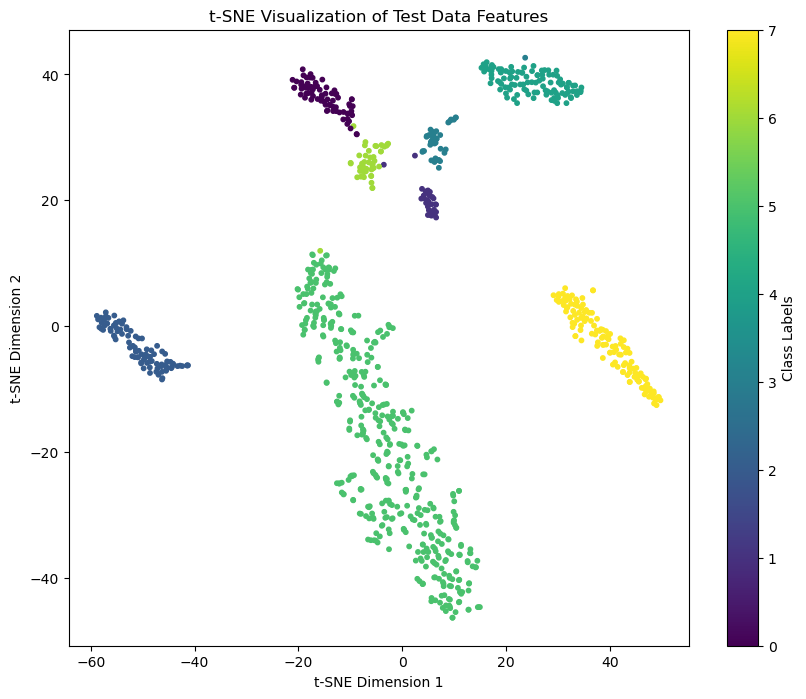

In [50]:
# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedded_space[:, 0], embedded_space[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar(scatter, label='Class Labels')
plt.title("t-SNE Visualization of Test Data Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()